In [ ]:
# checkpoint 10/27/18 
#  SINGLE SOMA works with Ina Ik Ica chi is the old version.
#  Icoup = 0.


# checkpoint 10/29/18 
# SPINE AND SOMA. STUCK at dchi/dt, chi coupling term.
# remaining question: how to use monitor.

# checkpoint 11/12/18
# ADDING CHICOUP TERM

# COPY-4 11/13/18
# TRY REARRANGE THE ORDER OF THE EQS.

In [2]:
from brian2 import *
# from numpy import matlib
import numpy as np
import matplotlib.pyplot as plt


In [54]:
start_scope()

defaultclock.dt = 0.025*ms


# FUNCTION SECTION
zetap = 30.  # This is 40 in Poirazi paper
tempc = 23.*kelvin


xx = 0.0853*(273.16 + tempc/kelvin)/2  # kelvin
tadj = 2.3**((tempc/kelvin-23)/10)   
q = 96480/(8.315*(273.16+tempc/kelvin))  
qt = 5**((tempc/kelvin-24)/10)  

qma = 0.000480*(1/ms)
qmb = 0.280000*(1/ms)
qhat = 1.



@implementation('cython',"""
def zeta(v):
    return -1.5-(1./(1.+exp((v+30.)/5.))) 
""")
@check_units(v=1, result=1)
def zeta(v):
    return -1.5-(1./(1.+exp((v+30.)/5.))) 
# zeta.stateless = True

@implementation('cython',"""
def zeta2(v):
    return -1.8-(1/(1+exp((v+40)/5)))  
""")
@check_units(v=1, result=1)
def zeta2(v):
    return -1.8-(1/(1+exp((v+40)/5)))  


@implementation('numpy',discard_units=True)
@check_units(z=1, result=1)  # z is volt, so when used should do eff(z/mV). see ghk(volt)
def eff(z):
    return ((1-z/2)*np.heaviside(0.0001-abs(z), 1)+\
            (z/(exp(z)-1))*np.heaviside(abs(z)-0.0001, 1))


@implementation('cython',"""
def salfa(v):
    return -0.055*(v+27.01)/(exp((-v-27.01)/3.8)-1) 
""")
@check_units(v=1, result=1)
def salfa(v):
    return -0.055*(v+27.01)/(exp((-v-27.01)/3.8)-1)  


@implementation('cython',"""
def sbeta(v):
    return 0.94*exp((-v-63.01)/17) 
""")
@check_units(v=1, result=1)
def sbeta(v):
    return 0.94*exp((-v-63.01)/17) 


# 1/10 scale
t_st = -100*ms
# impulse_duration = period*1.1  # 1.25*ms
# period = 300*ms
period = 1000*ms

t_delta = 10*ms

@implementation('numpy',discard_units=True)
@check_units(t=ms, result=1)
def fpost(t):
    return (np.heaviside((t-0.1*ms)/ms,0)*\
        (np.heaviside(sin(2*pi*(t-t_st-2*ms-t_delta)/period),1)*\
        (1 - np.heaviside(sin(2*pi*(t-t_st-t_delta-1*ms)/period),1))))


# @implementation('numpy',discard_units=True)
# @check_units(t=ms, result=1)
# def fpre(t):
#     return np.heaviside(np.heaviside((t-1*ms)/ms,0) *\
#                         np.heaviside(sin(2*pi*(t-t_st-1.1*ms)/period),1)*\
#                         (1 - np.heaviside(sin(2*pi*(t-t_st-1*ms)/period),1)),0)


@implementation('numpy',discard_units=True)
@check_units(t=ms, result=1)
def fpre(t):
    return (np.heaviside((t-1*ms)/ms,0) *\
            (np.heaviside(sin(2*pi*(t-t_st-1.1*ms)/period),1)*\
            (1 - np.heaviside(sin(2*pi*(t-t_st-1*ms)/period),1))))
    
#     return np.heaviside(np.heaviside((t-1*ms)/ms,0) *\
#                         np.heaviside(sin(2*pi*(t-t_st-1.1*ms)/period),1)*\
#                         (1 - np.heaviside(sin(2*pi*(t-t_st-1*ms)/period),1)),0)




# (np.heaviside((t-t_st)/ms,0)*np.heaviside(sin(2*pi*(t-t_st-period)/period),1)\
#             *(1 - np.heaviside(sin(2*pi*(t-t_st-period-1*ms)/period),1)))



# fpre(t)=synapse*heav(heav(t-1)*(heav(sin(6.2831853*(t-st-1.1)/period))\
# *(1-heav(sin(6.2831853*(t-st-1)/period))))) +ror*synapse*heav(heav(t-1)*\
# (heav(sin(6.2831853*(t-win-st-1.1)/period))*(1-heav(sin(6.2831853*(t-win-st-1)/period)))))  
# fpost(t)= heav(t-1)*(heav(sin(6.2831853*(t-2-st-delta)/period))*\
# (1-heav(sin(6.2831853*(t-1-st-delta)/period)))) + \
# oro*heav(t-1)*(heav(sin(6.2831853*(t-2-st-delta+win)/period))*\
# (1-heav(sin(6.2831853*(t-1-st-delta+win)/period))))  

In [55]:
# ----- SOMA ------ #

Nsoma = 1

# some calcium-related vars, table 2
pHC = 4.0*umolar
aHC = 0.6*umolar
pHN = 4.
aHN = 3.
alphav = 1.
alphab = 5.
alphad = 1.
thetav = 2.*umolar
thetad = 2.6
thetab = 0.55
Cp = 5.
Cd = 4.
taup = 500*ms
taua = 5*ms
tauv = 10*ms
taud = 250*ms
taub = 40*ms
sigmav = -0.05*umolar
sigmad = -0.01
sigmab = -0.02
p = 0.3
d = 0.01
kd = -0.002
kp = -0.1

alphaw = 0.8
betaw = 0.6
tauw = 500*ms

# some calcium-related vars, concentration
phisoma = 0.1*umolar/ms/(uamp*cm**-2)
betasoma = 0.083/ms
chi0soma = 0.05*umolar

phispin = 0.1*umolar/ms/(uamp*cm**-2)
betaspin = 0.083/ms
chi0spin = 0.07*umolar
nonc =  6.*umolar





# Ileak
glsoma = 0.1*msiemens/cm**2
glspin = 0.1*msiemens/cm**2
El = -70.*mV

# Ina
gNasoma = 30.*msiemens/cm**2
ENa = 60*mV
gNaspin = 7.*msiemens/cm**2
natt = 1.
asap=0.001
inact=72.
inact2=0.11
inact3=2.
inact4=64.
inact5=1.

# Ik; Iksoma = kdr + a + mahp; Ikspin = kdr + a
gkdrsoma = 14*msiemens/cm**2
gasoma = 7.5*msiemens/cm**2
gmahpsoma = 25*msiemens/cm**2
Ek = -80*mV
btaumod = 7.
gkdrspin = 0.867*msiemens/cm**2
gaspin = 12.*msiemens/cm**2


# Ica
gcalsoma = 7.0*uamp*cm**-2
gcalspin = 25.0*msiemens/cm**2
Eca = 140.*mV
s1=0.0
s2=40.
s3=3.6
vcanmda = 140.*mV
ca = 2.

# synapses strength
gnmda = 0.3*msiemens/cm**2
gcanmda = 25.*msiemens/cm**2
gampa = 0.05*msiemens/cm**2
# gcoup = 1.125*msiemens/cm**2
gcoup = 0.3*msiemens/cm**2

allowampa = 1.0
vsynrev = 0.0*mV
speedup =20.
nmdarate = 2.
ndf = 10.0
nds = 45.0   
block = 0.062
blockca =0.124
mg = 2.

# Iin
ipostinj = 62.5*uamp*cm**-2
# ginsoma = 1.*amp*meter**-2

Cm = 1 * ufarad/cm**2

eqs_soma = '''
dv/dt = ( ( Ileak +  Ina + Ik + Ica + Icoup + Iin))/Cm : volt


Ileak = glsoma * (El-v) : amp*meter**-2


Ina = gNasoma * mna**2 * hna * (ENa-v) : amp*meter**-2
# soma activation
alphams = 0.32*(-46.9-v/mV)/(exp((-46.9-v/mV)/4.0)-1.0)/ms :Hz
betams = 0.28*(v/mV+19.9)/(exp((v/mV+19.9)/5.0)-1.0)/ms :Hz
mna = alphams/(alphams+betams) : 1
dhna/dt=alphahs-(alphahs+betahs)*hna  :1
alphahs = 0.128*exp((-43.0-v/mV)/18.0)/ms :Hz
betahs = 4.0/(1.0+exp((-20.0-v/mV)/5.0))/ms :Hz



Ik = Ia + Ikdr + Imahp : amp*meter**-2

Ikdr = gkdrsoma * n_soma * (Ek - v) : amp*meter**-2
dn_soma/dt = alphans-(alphans+betans)*n_soma : 1 
alphans =  0.016*(-24.9-v/mV)/(exp((-24.9-v/mV)/5.0)-1.0)/ms : Hz  
betans =   0.25*exp(-1.0-0.025*v/mV)/ms  : Hz

Ia = gasoma * a_soma * b_soma * (Ek-v) : amp*meter**-2
da_soma/dt=(a_somainf-a_soma)/(a_somatau)  : 1
a_somainf=1/(1+a_smaalf)  : 1
a_smaalf=exp(0.001*zeta(v/mV)*(v/mV-11)*q)  : 1
a_smabet=exp(0.00055*q*(v/mV-11)*zeta(v/mV)) : 1
a_somatau=clip(a_smabet/((1+a_smaalf)*qt*0.05),0.1, inf)*ms : second
db_soma/dt=(b_somainf-b_soma)/(b_somatau) :1
b_somainf = 0.3+0.7/(1+exp(0.02*(v/mV+63.5)*q)) :1   
b_somatau = btaumod*clip(0.11*(v/mV+62),2,inf)*ms : second

Imahp = gmahpsoma * qm_soma * (Ek - v) : amp*meter**-2
dqm_soma/dt = (qm_smainf-qm_soma)/(qm_smatau)  :1
qm_smaalf = qma*chi/umolar/(0.001*chi/umolar + 0.18*exp(-1.68*v/mV*q)) : Hz 
qm_smabet = (qmb*exp(-0.022*v/mV*q))/(exp(-0.022*v/mV*q)+0.001*chi/umolar) : Hz  
qm_smatau = 1/(qm_smaalf+qm_smabet)  : second
qm_smainf = qhat*qm_smaalf*qm_smatau  : 1



Ica = -gcalsoma*s_soma*ghk*(1/(1+chi/umolar)) : amp*meter**-2
ghk = -xx*(1-((chi/umolar/ca)*exp(v/mV/xx)))*eff(v/mV/xx) :1
ds_soma/dt=(s_somainf-s_soma)/(s_somatau)  : 1
s_somainf=salfa(v/mV)/(salfa(v/mV)+sbeta(v/mV))  : 1
s_somatau=1/(5*(salfa(v/mV)+sbeta(v/mV)))*ms  : second

dchi/dt = phisoma*Ica - betasoma*(chi-chi0soma)  - (betasoma/nonc)*chi**2 + chicoup : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((A-thetab)/sigmab)) -B -Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((B-thetad)/sigmad)) -D)/taud : 1
chicoup  : mmolar/second

dw/dt = ( alphaw/(1+exp((P-p)/kp)) - betaw/(1+exp((D-d)/kd)) - w )/tauw :1 


Iin = ipostinj * fpost(t) :amp*meter**-2

Icoup :  amp*meter**-2
'''




# somas = NeuronGroup(Nsoma, eqs_soma, threshold='v>0*mV',refractory='v > 0*mV',method='rk4')
# somas.v = -60*mV
# somas.chi = 0.05*umolar

# Msoma = StateMonitor(somas, {'v','chi', 'Iin','Ina','Ik','Ica'} , record=True)



In [56]:
# ----- SPINE -----#

Nspin = 1

# TEST
# phispin = 0.0*umolar/ms/(uamp*cm**-2)

eqs_spin = '''
dv/dt = ( ( Ileak +  Ina + Ik + Ica + Icoup + Iampa + Inmda))/Cm : volt


Ileak = glspin * (El-v) : amp*meter**-2

Ina = gNaspin * m_spin**2 * h_spin * i_spin * (ENa-v) : amp*meter**-2
# soma activation
dm_spin/dt=(m_spininf-m_spin)/(m_spintau) :1
m_spininf=1/(1+exp((-v/mV-40)/3))  : 1
#m_spintau = max(0.1,0.05)   ???
m_spintau = 0.1*ms : second
dh_spin/dt=(h_spininf-h_spin)/(h_spintau)  :1
h_spininf=1/(1+exp((v/mV +45)/3))  :1
h_spintau=0.5*ms : second
di_spin/dt=(i_spininf-i_spin)/(i_spintau)  :1
i_spininf=(1+natt*exp((v/mV+60)/2))/(1+exp((v/mV+60)/2))  :1
i_spintau=clip((0.00333*exp(0.0024*(v/mV+60)*q))/(1+exp(0.0012*(v/mV+60)*q)),0.1,inf)*ms : second  


Ik = Ia + Ikdr : amp*meter**-2

Ikdr = gkdrspin * n_spin**2 * (Ek - v) : amp*meter**-2
dn_spin/dt=(n_spininf-n_spin)/(n_spintau)  :1
n_spininf=1/(1+exp((-v/mV-42)/2))  :1
n_spintau=2.2*ms : second

Ia = gaspin * a_spin * b_spin * (Ek-v) : amp*meter**-2
da_spin/dt=(a_spininf-a_spin)/(a_spintau)  :1
a_spnalf=exp(asap*zeta(v/mV)*(v/mV+1)*q)  :1
a_spininf=1/(1+a_spnalf)  :1
a_spnbet=exp(0.00039*q*(v/mV+1)*zeta2(v/mV))  :1
a_spintau= clip(a_spnbet/((1+a_spnalf)*qt*0.1),0.1,inf)*ms :second
db_spin/dt=(b_spininf-b_spin)/(b_spintau) :1
b_spininf= 0.3+0.7/(1+exp(inact2*(v/mV+inact)*q)) :1
b_spintau=btaumod*clip(inact3*(v/mV+inact4),inact5, inf)*ms : second


Ica = gcalspin * s_spin**3 * t_spin * (Eca - v)  : amp*meter**-2
ds_spin/dt=(s_spininf-s_spin)/(s_spintau)  :1
s_spininf=1/(1+exp(-v/mV-37))  :1
s_spintau= (s3+s1/(1+exp(v/mV+s2)))*ms  : second
dt_spin/dt=(t_spininf-t_spin)/(t_spintau)  :1
t_spininf=1/(1+exp((v/mV+41)/.5))  :1
t_spintau=29*ms : second


Iampa = allowampa*gampa*sampa*(vsynrev - v)  : amp*meter**-2
dsamparise/dt = (-speedup*(1-sampafast-sampaslow)*fpre(t)-(1/0.58)*samparise)/ms  :1
dsampafast/dt = (speedup*(0.903-sampafast)*fpre(t)-(1/7.6)*sampafast)/ms  :1
dsampaslow/dt = (speedup*(0.097-sampaslow)*fpre(t)-(1/25.69)*sampaslow)/ms  :1
sampa = sampafast+sampaslow+samparise  : 1



Inmda = gnmda*snmda*mnmda*(vsynrev - v)   : amp*meter**-2
Icanmda = gcanmda*snmda*mcanmda*(vcanmda - v)   : amp*meter**-2
dsnmdarise/dt = (-speedup*(1-snmdafast-snmdaslow)*fpre(t)-(1/nmdarate)*snmdarise)/ms  :1
dsnmdafast/dt = (speedup*(0.527-snmdafast)*fpre(t)-(1/ndf)*snmdafast)/ms  :1
dsnmdaslow/dt = (speedup*(0.473-snmdaslow)*fpre(t)-(1/nds)*snmdaslow)/ms  :1
snmda = snmdafast+snmdaslow+snmdarise :1
mnmda=    1/(1.0+0.3*mg*exp(-block*v/mV))  :1
mcanmda=  1/(1.0+0.3*mg*exp(-blockca*v/mV))  :1



dchi/dt = phispin*(Ica+Icanmda) - betaspin*(chi-chi0spin) -(betaspin/nonc)*chi**2 : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((A-thetab)/sigmab)) -B -Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((B-thetad)/sigmad)) -D)/taud : 1


Icoup :  amp*meter**-2

'''




# spines = NeuronGroup(Nsoma, eqs_spin, threshold='v>0*mV',refractory='v > 0*mV',method='rk4')
# spines.v = -60*mV
# spines.chi = 0.05*umolar

# Mspines = StateMonitor(spines, {'v','chi', 'Iin','Ina','Ik','Ica'} , record=True)



In [57]:
# INITIAL CONDITION
# somas = NeuronGroup(Nsoma, eqs_soma, threshold='v>0*mV',refractory='v > 0*mV',method='rk4')
somas = NeuronGroup(Nsoma, eqs_soma,method='rk4')
somas.v = -69.7516*mV
somas.chi = 0.0832192*umolar
somas.a_soma = 0.000370194
somas.b_soma = 0.994819
somas.hna = 0.997346
somas.n_soma =0.000402584
somas.qm_soma = 0
somas.s_soma = 2.19281e-05




# spines = NeuronGroup(Nspin, eqs_spin, threshold='v>0*mV',refractory='v > 0*mV',method='rk4')
spines = NeuronGroup(Nspin, eqs_spin ,method='rk4')
spines.v = -69.8996*mV
spines.chi = 0.0700397*umolar
spines.a_spin = 0.00117929
spines.b_spin = 1.
spines.h_spin = 0.999752
spines.i_spin = 0.992965
spines.m_spin = 4.69422e-05
spines.n_spin = 8.74318e-07
spines.s_spin = 6.03051e-15
spines.t_spin = 1






In [58]:


# ----- SYNAPSES------ #
# Coupling
eqs_coup = '''
Icoup_post = gcoup * (v_pre - v_post) : amp*meter**-2 (summed)
'''

C_coup_smsp = Synapses(somas, spines, model=eqs_coup, method='rk4')
C_coup_smsp.connect(condition='i == j')
C_coup_spsm = Synapses(spines, somas, model=eqs_coup, method='rk4')
C_coup_spsm.connect(condition='i == j')





# Msoma = StateMonitor(somas, {'v','chi', 'Iin','Ina','Ik','Ica'} , record=True)
# Msoma = StateMonitor(somas, {'v','chi'} , record=True)
Msoma = StateMonitor(somas, {'v','chi','Icoup','Iin','Ileak','Ina','Ik','Ica','w','P','A','V','B','D'} , record=True)

# Mspines = StateMonitor(spines, {'v','chi', 'Iin','Ina','Ik','Ica'} , record=True)
# Mspines = StateMonitor(spines, {'v','chi'} , record=True)
Mspines = StateMonitor(spines, {'v','chi','Ica','Ileak','Ina','Ik','Iampa','Inmda'} , record=True)
# Msmsp = StateMonitor(C_coup_smsp,{'Icoup_post'},record=True)
# Mspsm = StateMonitor(C_coup_spsm,{'Icoup_post'},record=True)



CaTauSoSp =1000.*ms
eqs_chi_coup = '''
chicoup_post = (chi_pre - chi_post)/CaTauSoSp  : mmolar/second (summed)
'''
C_chi_coup = Synapses(spines, somas, model=eqs_chi_coup, method='rk4')
# C_chi_coup.connect(condition='i == j')
C_chi_coup.connect()

In [59]:
# Mspines = StateMonitor(spines, {'v','chi', 'Iin','Ina','Ik','Ica'} , record=True)

duration = 20000*ms
run(duration,report='stdout')

Starting simulation at t=0. s for a duration of 20. s
0.382 (1%) simulated in 10s, estimated 8m 34s remaining.
0.740575 (3%) simulated in 20s, estimated 8m 40s remaining.
1.1189500000000001 (5%) simulated in 30s, estimated 8m 26s remaining.
1.5266250000000001 (7%) simulated in 40s, estimated 8m 4s remaining.
1.9022000000000001 (9%) simulated in 50s, estimated 7m 56s remaining.
2.3249 (11%) simulated in 1m 0s, estimated 7m 36s remaining.
2.7531000000000008 (13%) simulated in 1m 10s, estimated 7m 19s remaining.
3.1828000000000003 (15%) simulated in 1m 20s, estimated 7m 3s remaining.
3.611975 (18%) simulated in 1m 30s, estimated 6m 48s remaining.
4.039525 (20%) simulated in 1m 40s, estimated 6m 35s remaining.
4.44195 (22%) simulated in 1m 50s, estimated 6m 25s remaining.
4.8519250000000005 (24%) simulated in 2m 0s, estimated 6m 15s remaining.
5.282425 (26%) simulated in 2m 10s, estimated 6m 2s remaining.
5.710224999999999 (28%) simulated in 2m 20s, estimated 5m 50s remaining.
6.139675 (30

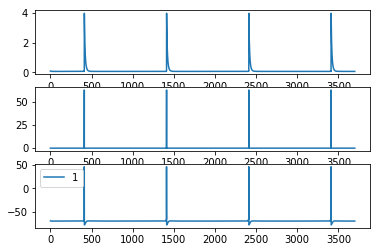

In [32]:
# Msoma = StateMonitor(somas, {'v','chi','Icoup','Iin','Ileak','Ina','Ik','Ica'} , record=True)
subplot(3,1,1)
plot(Msoma.t/ms,Msoma[0].chi/umolar)
subplot(3,1,2)
plot(Msoma.t/ms,Msoma[0].Iin/uamp*cm**2)
# plot(Msoma.t/ms,Msoma[0].Ileak/uamp*cm**2)
# plot(Msoma.t/ms,Msoma[0].Ina/uamp*cm**2)
# plot(Msoma.t/ms,Msoma[0].Ik/uamp*cm**2)
# plot(Msoma.t/ms,Msoma[0].Ica/uamp*cm**2)
# plot(Msoma.t/ms,Msoma[0].Icoup/uamp*cm**2)
subplot(3,1,3)
plot(Msoma.t/ms,Msoma[0].v/mV)
# xlim(40,70)
# plot(Msoma.t/ms,Msoma[0].w)


plt.legend(('1','2','3','4','5','6'))

Text(0.5,1,'chisoma')

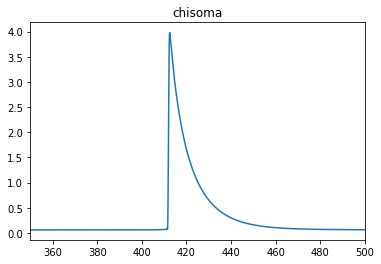

In [60]:
# plot(Msoma.t/ms,Msoma[0].v/mV)
# plot(Msoma.t/ms,Mspines[0].v/mV)
plot(Msoma.t/ms,Msoma[0].chi/umolar)

xlim(350,500)
title('chisoma')
# savefig('CHISOMA.pdf')


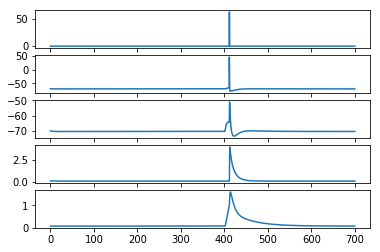

In [28]:
num_of_plot = 5
subplot(num_of_plot,1,1)
plot(Msoma.t/ms,Msoma[0].Iin/uamp*cm**2)
subplot(num_of_plot,1,2)
plot(Msoma.t/ms,Msoma[0].v/mV)
subplot(num_of_plot,1,3)
plot(Msoma.t/ms,Mspines[0].v/mV)

subplot(num_of_plot,1,4)
plot(Msoma.t/ms,Msoma[0].chi/umolar)
subplot(num_of_plot,1,5)
plot(Msoma.t/ms,Mspines[0].chi/umolar)


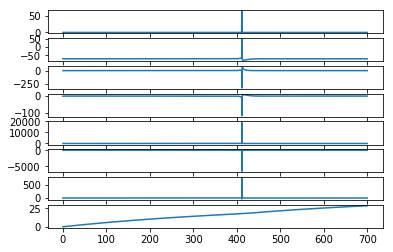

In [29]:
# Msoma = StateMonitor(somas, {'v','chi','Icoup','Iin','Ileak','Ina','Ik','Ica','w'} , record=True)

num_of_plot = 8
subplot(num_of_plot,1,1)
plot(Msoma.t/ms,Msoma[0].Iin/uamp*cm**2)
subplot(num_of_plot,1,2)
plot(Msoma.t/ms,Msoma[0].v/mV)
subplot(num_of_plot,1,3)
plot(Msoma.t/ms,Msoma[0].Icoup/mV)
subplot(num_of_plot,1,4)
plot(Msoma.t/ms,Msoma[0].Ileak/mV)
subplot(num_of_plot,1,5)
plot(Msoma.t/ms,Msoma[0].Ina/mV)
subplot(num_of_plot,1,6)
plot(Msoma.t/ms,Msoma[0].Ik/mV)
subplot(num_of_plot,1,7)
plot(Msoma.t/ms,Msoma[0].Ica/mV)
subplot(num_of_plot,1,8)
plot(Msoma.t/ms,Msoma[0].w/mV)







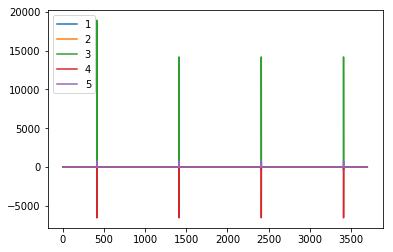

In [34]:
plot(Msoma.t/ms,Msoma[0].Icoup/mV)
plot(Msoma.t/ms,Msoma[0].Ileak/mV)
plot(Msoma.t/ms,Msoma[0].Ina/mV)
plot(Msoma.t/ms,Msoma[0].Ik/mV)
plot(Msoma.t/ms,Msoma[0].Ica/mV)

plt.legend(('1','2','3','4','5','6'))
# plt.xlim((60,70))

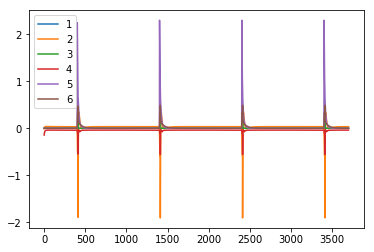

In [35]:
# Mspines = StateMonitor(spines, {'v','chi','Ica','Ileak','Ina','Ik','Iampa','Inmda'} , record=True)

plot(Msoma.t/ms,Mspines[0].Ica/(uamp/cm**2))
plot(Msoma.t/ms,Mspines[0].Ileak/(uamp/cm**2))
plot(Msoma.t/ms,Mspines[0].Ina/(uamp/cm**2))
plot(Msoma.t/ms,Mspines[0].Ik/(uamp/cm**2))
plot(Msoma.t/ms,Mspines[0].Iampa/(uamp/cm**2))
plot(Msoma.t/ms,Mspines[0].Inmda/(uamp/cm**2))

plt.legend(('1','2','3','4','5','6'))
# plt.xlim((60,70))

Text(0.5,1,'W')

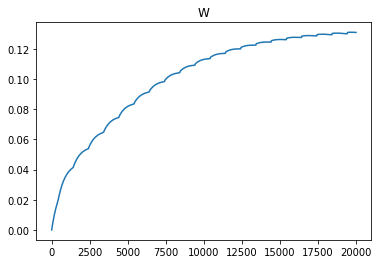

In [61]:
plot(Msoma.t/ms,Msoma[0].w)
# plt.xlim((0,1000))
title('W')
# savefig('W.pdf')


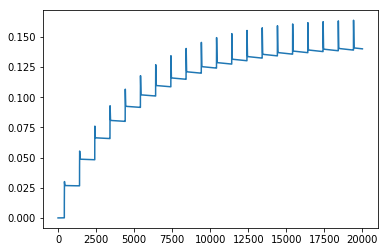

In [62]:
plot(Msoma.t/ms,Msoma[0].P)


In [131]:
t_test= np.linspace(0,1,1001)

In [135]:
fpre(t_test*ms)

ValueError: invalid number of arguments